# Natural Language Processing- Applied Machine Learning Final Project
#### Javier Rodriguez, Edgar Leon
#### Section ??

## Introduction

Social media used to be an avenue to share photos of your self, family, and friends with others. It was a way to keep in touch with friends and family far away and it was the perfect platform to share life updates. However, in recent years social media has taken up a larger role in our daily lives. For many the perfect morning routine consists of logging into their social media accounts where they catch up on the latest updates from their friends lives, latest celebrity gossip, and the latest news. More and more people are incorporating social media as their platform to share updates regarding flash news. Instead of turning on the TV to get the latest update from the news channels, people are turning towards social media users to post updates in real time. With social media's growing presence in the world of flash news, it only makes sense to harness the power of that tool to address emergency situations faster. Twitter is used by almost everyone all over the world, that means this social medial platform is a great source of information, especially for those who are interested in monitoring tweets about emergencies, for example like the police.

The kaggle project chosen is called "Natural Language Processing with Disaster Tweets" https://www.kaggle.com/competitions/nlp-getting-started. However, even though the language used in twitter might indicate danger, disaster, or emergency, it may not refer to an emergency or a disaster. Human beings love to use metaphors to communicate information. Metaphors are used to highlight the characteristics of one thing by comparing it to another thing, and is not meant to be taken literally. Expressions such as "Our football team was on fire tonight!" do not refer to a real fire. The goal of building this algorithm is to be able to classify twitter tweets into whether they indicate a real emergency or not.

For this final project the team created a natural language processing model that analyzes tweets to determine whether they indicate a real emergency. To aide the model, the team utilized GloVe: Global Vecttors for Word Representations. Homework, Async lectures, and the recommended text for the class "Deep Learning with Python" written by Francois Chollet were referenced to help build the model.

## Import Libraries

Before we begin building the models a few libraraies that we will be used in the project are loaded below.

In [ ]:
!pip install altair==5.2.0 #collab default is 4.2.2<-not working

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.9/996.9 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: altair
    Found existing installation: altair 4.2.2
    Uninstalling altair-4.2.2:
      Successfully uninstalled altair-4.2.2


In [ ]:
import altair as alt
print(alt.__version__)

5.2.0


In [ ]:
!pip install gensim #needed to import fast text twitter embeddings


In [ ]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import time
import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay, accuracy_score


import os
import pathlib

import math
import plotly.graph_objs as plotly  # for interactive plots

## For GridSearch
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC  # Replace with the model you want to use for grid search
#import altair as alt #to make nice plots
import re

## Import Twitter Based Embeddings
#### Source:

For this project, we chose to start the project off with a pre-trained word embeddings in twitter. The pre-trained word embeddings we used was GloVe, which was trained on global word-word co-occurance statistics from a large text data set. It contains 400,000 words of 50 dimensional vectors.

In [ ]:

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Navigate to the Directory Containing the CSV File
import os
os.chdir('/content/drive/My Drive/DS266 Project')


Get Data

In [ ]:
# Read the CSV File
import pandas as pd
tweets_df = pd.read_csv('train.csv')

In [ ]:
tweets_df.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [ ]:
from gensim.models import KeyedVectors

# Load vectors directly from the file
vector_model = KeyedVectors.load_word2vec_format('fasttext_english_twitter_100d.vec')




### Some Sanity Check Tests

After downloading Fast Text Tweet Embeddings we did a quick sanity check to see if some of the words we anticipate to commonly show up in our tweets text are captured.

In [ ]:
#key error handling
def check_word(item_value, model):
  word = None
  #print(model[item_value])
  #print(item_value)
  try:
    if model[item_value].any():
      word = "\""+item_value +"\" exists in embeddings dictionary"
      vector = model[item_value]
  except:
    word = "\""+item_value +"\" does not exist"
    vector = np.zeros((100,))
  return word, vector



In [ ]:
check = ['fire', 'hurricane', 'earthquake', 'sunami', 'disaster']
for i in range(len(check)-0):
  word, vector = check_word(check[i], vector_model)
  print(word)
  print(vector.shape)

"fire" exists in embeddings dictionary
(100,)
"hurricane" exists in embeddings dictionary
(100,)
"earthquake" exists in embeddings dictionary
(100,)
"sunami" does not exist
(100,)
"disaster" exists in embeddings dictionary
(100,)


Since 'sunami' does not exist, then we have to train our embeddings on our data.

## Inputing in Tweets Data Source

The kaggle competition provided us with training and testing data sets in the form of a csv file. The training csv files comes with five columns of data. The first colum is id. The keyword column contains a keyword associated with the tweet text. The location field is populated if the user tagged to it. One caveat to the data is that the keywords and location fields might not always be populated. the text field containst the original tweet. The final column is a 0 or 1 label value. If a tweet is classified as indicating a true emergency then the label is 1 otherwise its 0.

### Initial Data Exploratory Analysis

Our firs step was to conduct initial exploratory analysis. We checked the head or tails of the dataset to make sure the data formatting stays consistent.

In [ ]:
# import csv
#user_results_df.loc[user_results_df["category"] == "I", "pad_radius"] = user_results_df.iloc[1]['score']
tweets_df = pd.read_csv('train.csv')
tweets_df.loc[tweets_df["keyword"].isnull(), "keyword" ] = ''
tweets_df.loc[tweets_df["location"].isnull(), "location" ] = ''
size = tweets_df.shape
tweets_df[100:105].head(5)

,id,keyword,location,text,target
100,144,accident,UK,.@NorwayMFA #Bahrain police had previously die...,1
101,145,accident,"Nairobi, Kenya",I still have not heard Church Leaders of Kenya...,0
102,146,aftershock,Instagram - @heyimginog,@afterShock_DeLo scuf ps live and the game... cya,0
103,149,aftershock,304,'The man who can drive himself further once th...,0
104,151,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/yN...,0


Keyword is an interesting field in the training data set. The keyword field identifies the word in the twitter text that could potential indicate whether or not it is a tweet regarding an emergency. To get a better understanding of the keywords we created a bar graph to show the 10 most commonly identified keywords. From the bar graph below we can see that most of these words relate to some sort of danger or natural disaster, but there are some words on this list that are suprising: for example fear. Fear is a feeling and not really a disaster, it is surprising to see this word as a keyword. Another interesting keyword is body%20bags:

<Axes: >

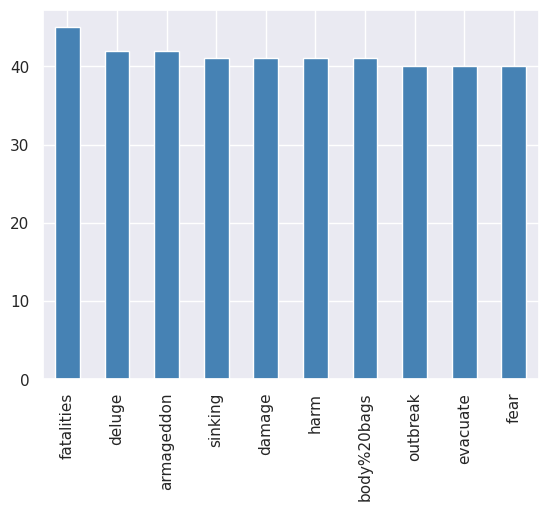

In [ ]:
tweets_df.keyword.value_counts().nlargest(10).plot(kind='bar', color = ['steelblue'])

Taking a further look into "body%20bags" we can see that majority of the tweets look like they are a handbag advertisements aimed at women.

In [ ]:
body20bags = tweets_df[tweets_df['keyword']=='body%20bags']
print(body20bags['text'][1:5])

1019    Micom 2015 Summer Contrast Candy Color Bowknot...
1020    HOBO Hobo Vintage Shira Convertible BÛ_ $238....
1021    Child Shoulder Bags PVC Shoulder Book Bag Cart...
1022    Womens Buckle Casual Stylish Shoulder Handbags...
Name: text, dtype: object


The next data field that was of interest is the target field. The target field identifies tweets as emergency tweets and non emergency tweets. To get a better idea of the distribution of emergency and non emergency tweets a simple histogram is created. Based off of the histogram below it looks like the training data set has more non emergency related tweets.

Text(0.5, 1.0, 'Distribution of Tweets and its Labels')

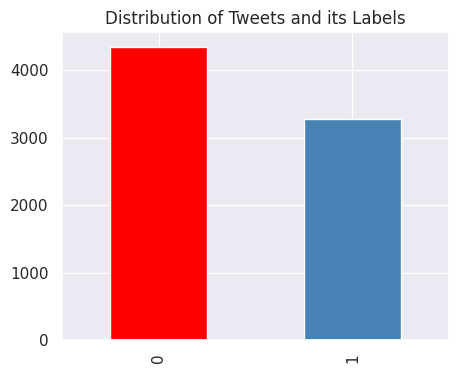

In [ ]:

barplot = tweets_df['target'].value_counts()
barplot.plot(kind = 'bar', figsize=(5,4), color = ['red', 'steelblue'])
plt.title("Distribution of Tweets and its Labels")

To get a better idea if the keyword field has an impact correlates to one of the labels on whether or not a tweet a bar plot was created.

Based off of this graph we can see that majority of the tweets with a keywords were identified as not an emergency tweet. By looking at this graph and analyzing some of the tweets with keywords identified we can say that just because a tweet has a keyword, it does not mean that it is a tweet indicates an emergency.

Text(0.5, 1.0, 'Tweets that have a keyword Identified, Count of Actual Disaster Tweets(1) vs Not Actual Disaster Tweets (0)')

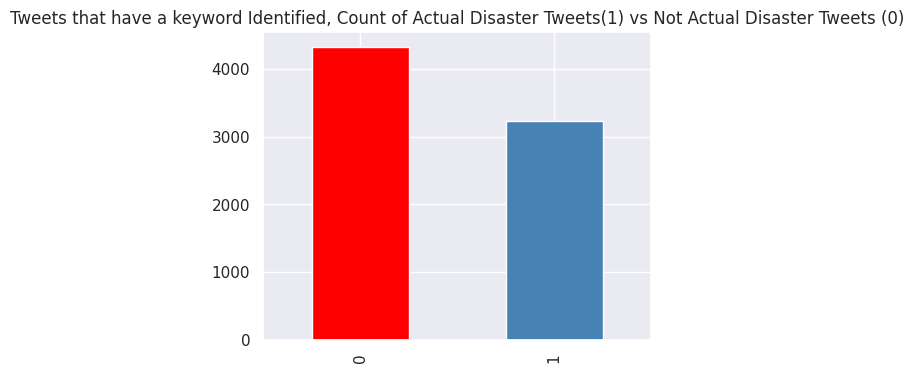

In [ ]:
tweets_df['HasKeyword'] = np.where(tweets_df['keyword'].isnull(), 'No', 'Yes')
tweets_df['HasLocation'] = np.where(tweets_df['location'].isnull(), 'No', 'Yes')


barplot = tweets_df[tweets_df['HasKeyword']=='Yes']['target'].value_counts()
barplot.plot(kind = 'bar', figsize=(5,4), color = ['red', 'steelblue'])
plt.title("Tweets that have a keyword Identified, Count of Actual Disaster Tweets(1) vs Not Actual Disaster Tweets (0)")

Lets analyze the correlation of specific keywords with the labels

In [ ]:
kwords = tweets_df[tweets_df.HasKeyword == 'Yes'].copy(deep=True)
#user_results_df.iloc[1]['score']
#count true labels of  for each keyword and plot
kw = kwords.keyword.unique()
keyw_dict = { }
for i in range(kw.shape[0]):
    keyw_dict[kw[i]] = 0

for i in range(kwords.shape[0]):
    if kwords.iloc[i]['target'] == 1:
        keyw_dict[kwords.iloc[i]['keyword']] += 1
#convert to dataframe and sort
key_df = pd.DataFrame(keyw_dict.items(), columns = ['keyword', 'true disaster'])
key_df = key_df.sort_values(by='true disaster')


#count false labels for each keyword
keyw_false = { } #tweets that are false disasters
for i in range(kw.shape[0]):
    keyw_false[kw[i]] = 0

for i in range(kwords.shape[0]):
    if kwords.iloc[i]['target'] == 0:
        keyw_false[kwords.iloc[i]['keyword']] += 1
#convert to dataframe and sort
key_df2 = pd.DataFrame(keyw_false.items(), columns = ['keyword', 'false disaster'])
#key_df2 = key_df2.sort_values(by='false disaster')
key_df2


key_df['false disaster'] =key_df2['false disaster']
key_df['total count'] = key_df['true disaster'] + key_df['false disaster']
key_df['percent false'] =(key_df['false disaster']/key_df['total count'] )*100


In [ ]:
source = key_df
count_true = alt.Chart(source).mark_point(filled=True, shape='triangle-up', size=120, color='black').encode(
    x= alt.X("keyword:N", sort='y'),
    y=alt.Y("true disaster:Q"),
    tooltip=[alt.Tooltip('true disaster:Q', title='total count labeled true')]
)

base = alt.Chart(source).encode(
    x= alt.X("keyword:N", sort=alt.EncodingSortField(field="true disaster")),
    y=alt.Y("percent false:Q"),
    tooltip=[alt.Tooltip('percent false:Q', title="percent false")]
)

bar = base.mark_bar(width = 10, color='red').encode(


)

text = base.mark_text(angle=270, yOffset=-50).encode(
        text = 'percent false:Q'

)

keyw_label3 = alt.Chart(source).mark_line(color='black').encode(
    x= alt.X("keyword:N", sort=alt.EncodingSortField(field="true disaster")),
    y=alt.Y("total count:Q"),

)

keyw_label4 = alt.Chart(source).mark_point(color='black').encode(
    x= alt.X("keyword:N", sort=alt.EncodingSortField(field="true disaster")),
    y=alt.Y("total count:Q"),
    tooltip=[alt.Tooltip('total count:Q', title="total keyword count")],
)


bar +text+ keyw_label3 +keyw_label4 + count_true

alt.LayerChart(...)

As you can see above keywords such as 'electrocute' are completely associated with a false disaster label, where as 'wreckage' on the other end are 100% labeled as true disaster.

##Is the keyword already part of the text field?

In [ ]:
#iterate over rows and identify missing keywords
missing_dict = { }
for i in range(kw.shape[0]):
    missing_dict[kw[i]] = 0

count = 0
for i in range(tweets_df.shape[0]):
    if tweets_df['HasKeyword'][i] == 'Yes':
        # initializing string
        word = tweets_df['keyword'][i]
        # printing original string
        mystring=tweets_df['text'][i]
        mystring = mystring.lower() #lower case
        # Expression evaluation in String
        # Using eval()
        if word not in mystring:
            missing_dict[word] += 1
            #print(word+" not found at index ", i)
            count+=1
#print(count/tweets_df.shape[0])




In [ ]:
# initialize list of lists
per_missing = count/tweets_df.shape[0]
per_found = (tweets_df.shape[0] - count)/tweets_df.shape[0]
data = [[per_missing , per_found]]

# Create the pandas DataFrame
pie_df = pd.DataFrame(data, columns=['Missing', 'Found'])
missing_df = pd.DataFrame(missing_dict.items(), columns=['Missing word', 'count'])
missing_df = missing_df.sort_values(by='count')

# print dataframe.
pie_df = pie_df.melt([], var_name='status', value_name='percentage')
base = alt.Chart(pie_df).encode(
    theta=alt.Theta("percentage:Q").stack(True),
    )

pie_chart = base.mark_arc().encode(
    color=alt.Color("status:N"),
    )

pie_text = base.mark_text(radius=60, size=20, color='black').encode(
    text="percentage:Q"
    )



pie_chart + pie_text

alt.LayerChart(...)

Is the keyword already part of the text field? The data analyis above shows that 20% of the entries are not. Some of those missing keywords, such as airplane20%accident have close 100% correrlation with a label of 1. Therefore we should insert those keywords into the text taking care not to insert if its already in the text.

A similar analysis was conducted with the location field. The bar graph below shows all the rows of data with a location field populated and the distribution of emergency tweets to non emergency tweets. Just because location is identified for that tweet it does not always mean that the tweet is indicating some sort of emergency or disaster. One example of this is, some tweets have #blacklivesmatter as their location, which is not an actual location but an emphasis to the point of the tweet. Therefore, locations are used for uncontrolled reasons and not always for tagging a physical location.

##Tweets that have a Location Identified:

Text(0.5, 1.0, 'Count of False Disaster (0) vs True Disaster(1) ')

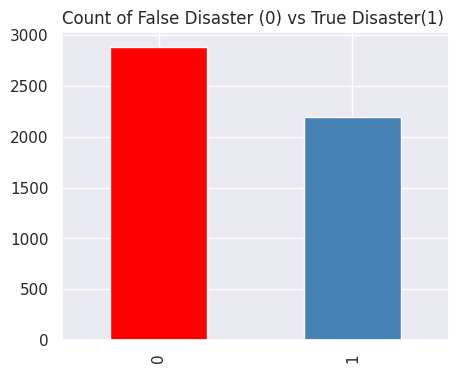

In [ ]:
barplot2 = tweets_df[tweets_df['HasLocation']=='Yes']['target'].value_counts()
barplot2.plot(kind = 'bar', figsize=(5,4), color = [ 'red', 'steelblue'])
plt.title("Count of False Disaster (0) vs True Disaster(1) ")

## Location and News

We suspect that if tweet references the news and the user also tags the tweet with a location then its more likely to be a true disaster. The following bar plot explores it.

In [ ]:
#building the dataframe to identify if tweet has location and news
lkwords = tweets_df[tweets_df['HasLocation']=='Yes'].copy(deep=True)
lkwords.reset_index(inplace = True)
source = lkwords
word1 = "news"


start_time = time.time()
source['comma']=0
count = 0
for i in range(source.shape[0]):
    mystring = source.iloc[i]['text']
    #word="like a" #metaphorical word
    #print(word)
    if isinstance(mystring, str):
        if word1 in mystring:
            source['comma'][i] = 1
            count+=1
            #print(i)
    #print('percent complete: %1.4f'%(i/(source.shape[0] )), end ="\r", flush=True)



print("\n--- %s seconds ---" % (time.time() - start_time))


<ipython-input-22-1a516ec2345e>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source['comma'][i] = 1



--- 0.49833202362060547 seconds ---


Text(0.5, 1.0, 'Tweets with News and Location')

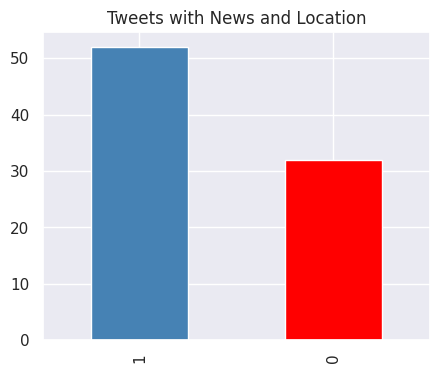

In [ ]:


title= "Tweets with News and Location"
barplot2 = source[source['comma']==1]['target'].value_counts()
barplot2.plot(kind = 'bar', figsize=(5,4), color = ['steelblue', 'red'])
plt.title(title)

In [ ]:
#use the following to further clean text
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*',
          '+', '\\', '•', '~', '@', '£',
          '·', '_', '{', '}', '©', '^', '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 'Â', '█',
          '½', 'à', '…',
          '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥',
          '▓', '—', '‹', '─',
          '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾',
          'Ã', '⋅', '‘', '∞',
          '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹',
          '≤', '‡', '√', '..', '...', '…']

Clearly, the above the distribution is not even when considering this subset. For our model we should not discard the tag location of a tweet, even though it may not be a real location.

### Check for metaphorical and entertainment words

##More Words
words from:
https://thecontentauthority.com/blog/words-related-to-sports-with-meaning#:~:text=Definitions%20For%20Our%20List%20Of%20Words%20Related%20To,7%20Swimming%20...%208%20Golf%20...%20More%20items

https://www.britannica.com/dictionary/eb/3000-words/topic/american-sports-vocabulary-english/3

https://relatedwords.io/entertainment

https://relatedwords.io/sports

https://relatedwords.io/accident

https://relatedwords.io/disaster






In [ ]:
# Modify this path to where you saved the Shakespear data in your Drive
text_file1 = './word_salads/ent_list1.txt'
text_file2 = './word_salads/disaster_list1.txt'
text_file3 = './word_salads/accident_list1.txt'
text_file4 = './word_salads/sports_list1.txt'
text_file5 = './word_salads/sports_list2.txt'

word_list =[]
lines =[]

with open(text_file1, encoding='ISO-8859-1') as f:
    word_list = f.read().split('\n')



with open(text_file4, encoding='ISO-8859-1') as f:
    lines = f.read().split('\n')

word_list.extend(lines)
lines =[]

with open(text_file5, encoding='ISO-8859-1') as f:
    lines = f.read().split('\n')

word_list.extend(lines)
lines =[]

# Convert all words in word_list to lowercase
word_list = [word.lower() for word in word_list]


In [ ]:
word_list[100:120], len(word_list)

(['merchandising',
  'scheherazade',
  'curiosity',
  'happiness',
  'epic',
  'audience',
  'commentary',
  'meme',
  'multiplatform',
  'poker',
  'showbiz',
  'escape',
  'bars',
  'opera',
  'performance poetry',
  'audiobook',
  'camping',
  'running',
  'fraxinus',
  'carnival'],
 1273)

The results below show that metaphorical and entertainment words do have a strong tendency towards the false label. These are words that would normally be used in conjunction with the description of a disaster: for example: "Today he played football like a hurricane". Tweets that contain such words have a higher percentage of being labeld false. Therefore we should deploy a model that will detect a combination of words (where order matters like in a permutation) in subsets of the text; group of words that convert a phrase into a metaphore.

In [ ]:
import string
mwords = tweets_df.copy(deep=True)
mwords.reset_index(inplace = True)
start_time = time.time()
mwords['non-disaster-marker'] = 0
count = 0
found_words = []
found_indices = []
#word_list =['may', 'disaster', 'music', 'shelter']

for i in range(mwords.shape[0]):
#for i in range(4):
  check_txt = mwords.iloc[i]['text']
  check_txt = check_txt.lower()
  check_txt = check_txt.translate(str.maketrans('', '', string.punctuation))

  if isinstance(check_txt, str):
      # Split the check_txt into words
      words_in_txt = check_txt.split()
      #print("check_txt: ", check_txt)
      #print('words_in_text: ', words_in_txt)
      for word in word_list:
          # Skip if word is an empty string
          if word.strip() == '':
            #print('we continue ', i)
            continue

          # Split the word into subwords
          subwords = word.split()
          #print('subwords: ',subwords)
          # Check if all subwords are in the list of words in check_txt
          if all(subword in words_in_txt for subword in subwords):
              #print('word found: ', word)
              #print('subwords: ', subwords)
              found_words.append(word)
              found_indices.append(word_list.index(word))
              mwords['non-disaster-marker'][i] = 1
              count += 1
print("words found: ", count)
#print("found words: ", found_words)
#print("found indices: ", found_indices)

<ipython-input-158-e424724e633e>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mwords['non-disaster-marker'][i] = 1


words found:  6832


Text(0.5, 1.0, 'Tweets with Words Associated with Entertainment')

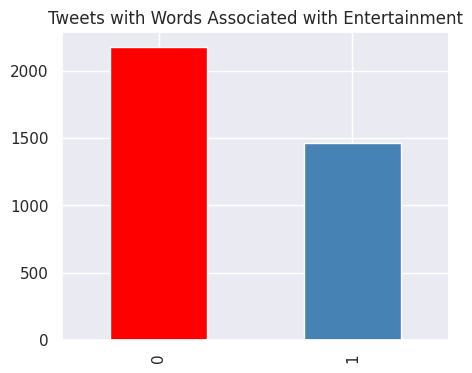

In [ ]:
title="Tweets with Words Associated with Entertainment"
barplot2 = mwords[mwords['non-disaster-marker']==1]['target'].value_counts()
barplot2.plot(kind = 'bar', figsize=(5,4), color = ['red', 'steelblue'])
plt.title(title)

Checking if the presence of the word Disaster is indicative of a True Label:

In [ ]:
# Modify this path

text_file2 = './word_salads/disaster_list1.txt'
text_file3 = './word_salads/accident_list1.txt'


disaster_list =[]
lines =[]

with open(text_file2, encoding='ISO-8859-1') as f:
    disaster_list = f.read().split('\n')



#with open(text_file3, encoding='ISO-8859-1') as f:
#    lines = f.read().split('\n')

disaster_list.extend(lines)


# Convert all words in disaster_list to lowercase
disaster_list = [word.lower() for word in disaster_list]


In [ ]:
disaster_list[0:20]

['emergency',
 'tragedy',
 'catastrophe',
 'tsunami',
 'earthquake',
 'crisis',
 'devastation',
 'accident',
 'famine',
 'hurricane',
 'calamity',
 'destruction',
 'catastrophic',
 'flood',
 'quake',
 'visitation',
 'hardship',
 'meltdown',
 'damage',
 'cataclysm']

In [ ]:
import string
mwords = tweets_df.copy(deep=True)
mwords.reset_index(inplace = True)
start_time = time.time()
mwords['disaster-marker'] = 0
count = 0
found_words = []
found_indices = []


for i in range(mwords.shape[0]):
#for i in range(4):
  check_txt = mwords.iloc[i]['text']
  check_txt = check_txt.lower()
  check_txt = check_txt.translate(str.maketrans('', '', string.punctuation))

  if isinstance(check_txt, str):
      # Split the check_txt into words
      words_in_txt = check_txt.split()
      #print("check_txt: ", check_txt)
      #print('words_in_text: ', words_in_txt)
      for word in disaster_list:
          # Skip if word is an empty string
          if word.strip() == '':
            #print('we continue ', i)
            continue

          # Split the word into subwords
          subwords = word.split()
          #print('subwords: ',subwords)
          # Check if all subwords are in the list of words in check_txt
          if all(subword in words_in_txt for subword in subwords):
              #print('word found: ', word)
              #print('subwords: ', subwords)
              found_words.append(word)
              found_indices.append(disaster_list.index(word))
              mwords['disaster-marker'][i] = 1
              count += 1
print("words found: ", count)
#print("found words: ", found_words)
#print("found indices: ", found_indices)

<ipython-input-170-9c34854dbac7>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mwords['disaster-marker'][i] = 1


words found:  8059


Text(0.5, 1.0, 'Tweets with Words Associated with Disaster')

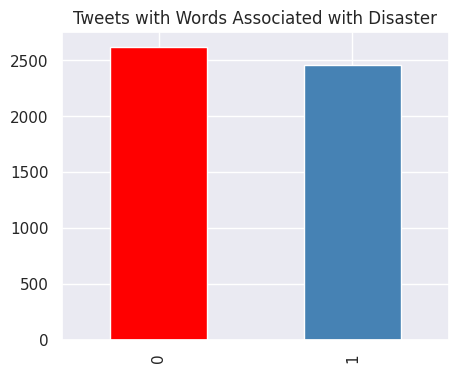

In [ ]:
title="Tweets with Words Associated with Disaster"
barplot2 = mwords[mwords['disaster-marker']==1]['target'].value_counts()
barplot2.plot(kind = 'bar', figsize=(5,4), color = ['red', 'steelblue'])
plt.title(title)

### Checking if the presence of a Hyperlink URL is indicative of a real disaster

The results show that the presence of a URL in the tweet is equally distributed between True and False

In [ ]:
uwords = tweets_df.copy(deep=True)
uwords.reset_index(inplace = True)
source = uwords
word1 = "http"

start_time = time.time()
source['comma']=0
count = 0
for i in range(source.shape[0]):
    mystring = source.iloc[i]['text']
    #word="like a" #metaphorical word
    #print(word)
    if isinstance(mystring, str):
        if word1 in mystring:
            uwords['comma'][i] = 1
            count+=1
            #print(i)
    #print('percent complete: %1.4f'%(i/(uwords.shape[0] )), end ="\r", flush=True)


print("\n--- %s seconds ---" % (time.time() - start_time))


<ipython-input-173-f9f48d750851>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uwords['comma'][i] = 1



--- 2.1638877391815186 seconds ---


Text(0.5, 1.0, 'Tweets that Contain a URL')

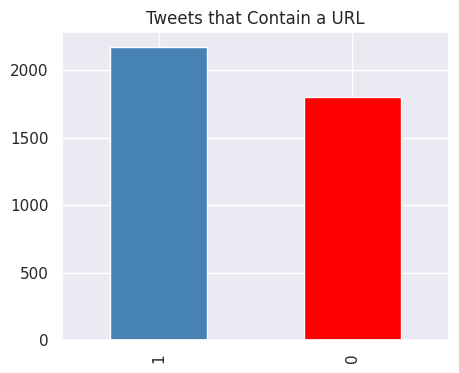

In [ ]:
title = "Tweets that Contain a URL"
barplot2 = source[source['comma']==1]['target'].value_counts()
barplot2.plot(kind = 'bar', figsize=(5,4), color = ['steelblue', 'red'])
plt.title(title)

### News

If a user referenes the news in the tweet, this may be indicative that a real disaster is happening.

In [ ]:
nwords = tweets_df.copy(deep=True)
nwords.reset_index(inplace = True)

In [ ]:
source = nwords
source.shape

(7613, 8)

In [ ]:
source = nwords
word1 = "news"

start_time = time.time()
source['comma']=0
count = 0
for i in range(source.shape[0]):
    mystring = source.iloc[i]['text']
    #word="like a" #metaphorical word
    #print(word)
    if isinstance(mystring, str):
        if word1 in mystring:
            source['comma'][i] = 1
            count+=1
            #print(i)
    print('percent complete: %1.4f'%(i/(source.shape[0] )), end ="\r", flush=True)



print("\n--- %s seconds ---" % (time.time() - start_time))


<ipython-input-175-021dcc77c24a>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source['comma'][i] = 1



--- 14.128360986709595 seconds ---


In [ ]:
print(100*count/source.shape[0])


1.7207408380401945


Text(0.5, 1.0, "Tweets with the word News', Count of Actual emergency Tweets(1) vs Not Actual emergency Tweets (0)")

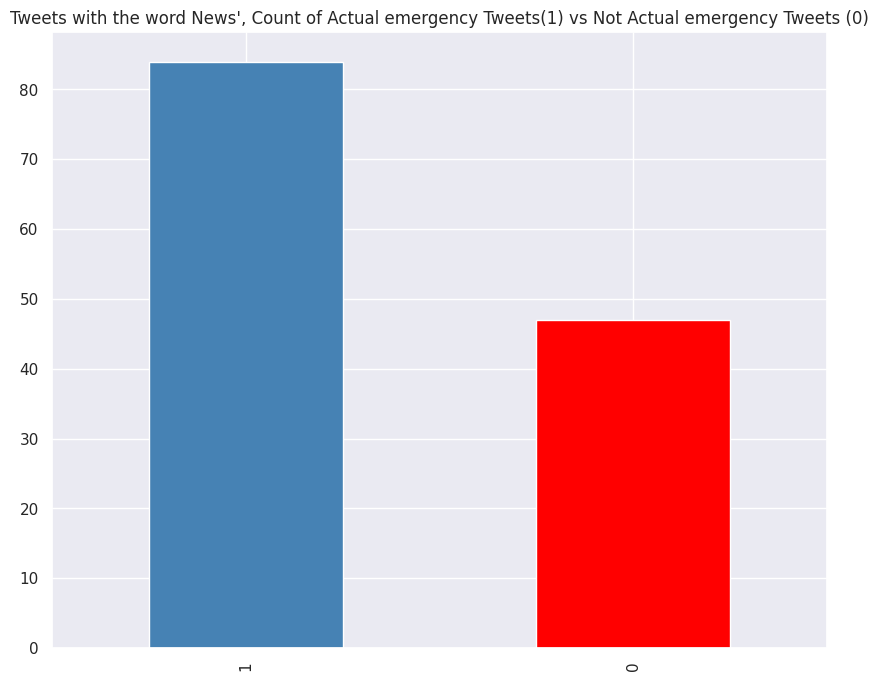

In [ ]:

barplot2 = source[source['comma']==1]['target'].value_counts()
barplot2.plot(kind = 'bar', figsize=(10,8), color = ['steelblue', 'red'])
plt.title("Tweets with the word News', Count of Actual emergency Tweets(1) vs Not Actual emergency Tweets (0)")

### News and URL together

The presence of the word News and a URL in the text is a stronng indication that the label is True

In [ ]:
nwords = tweets_df.copy(deep=True)
nwords.reset_index(inplace = True)

In [ ]:

source = nwords
word1 = "news"
word2 = "http"

start_time = time.time()
source['comma']=0
count = 0
for i in range(source.shape[0]):
    mystring = source.iloc[i]['text']
    #word="like a" #metaphorical word
    #print(word)
    if isinstance(mystring, str):
        if word1 in mystring and word2 in mystring:
            source['comma'][i] = 1
            count+=1
            #print(i)
    print('percent complete: %1.4f'%(i/(source.shape[0] )), end ="\r", flush=True)



print("\n--- %s seconds ---" % (time.time() - start_time))


<ipython-input-179-bc097d047135>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source['comma'][i] = 1



--- 14.596794605255127 seconds ---


In [ ]:
print(100*count/source.shape[0])

Text(0.5, 1.0, 'Tweets with News and URL, Count of Actual emergency Tweets(1) vs Not Actual emergency Tweets (0)')

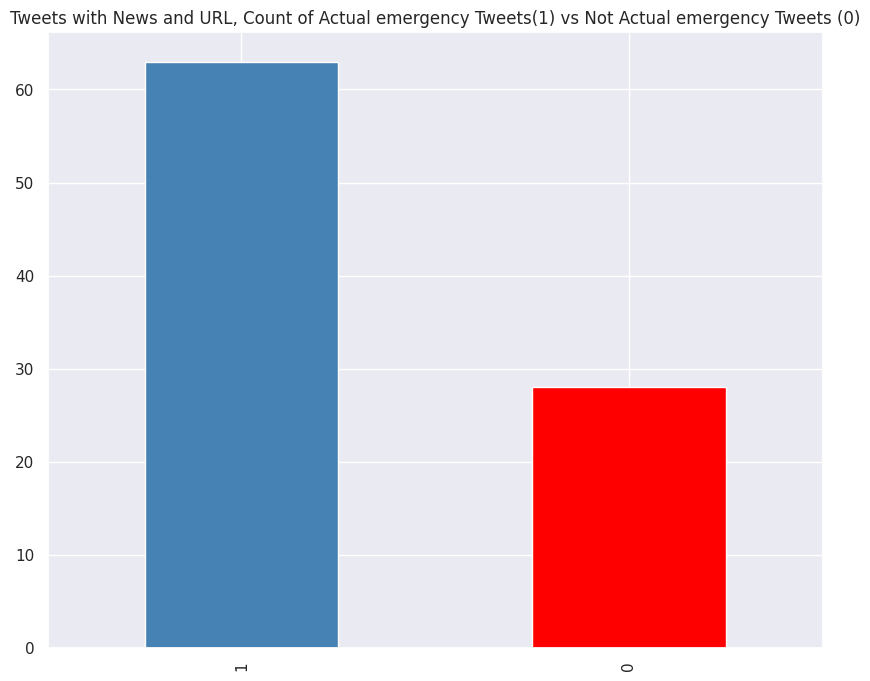

In [ ]:

barplot2 = source[source['comma']==1]['target'].value_counts()
barplot2.plot(kind = 'bar', figsize=(10,8), color = ['steelblue','red'])
plt.title("Tweets with News and URL, Count of Actual emergency Tweets(1) vs Not Actual emergency Tweets (0)")

### Hashtag

A hashtag is not an indicator that the label is True

In [ ]:
hwords = tweets_df.copy(deep=True)
hwords.reset_index(inplace = True)

In [ ]:

source = hwords
word1 = "#"
#word2 = "http"

start_time = time.time()
source['comma']=0
count = 0
for i in range(source.shape[0]):
    mystring = source.iloc[i]['text']
    #word="like a" #metaphorical word
    #print(word)
    if isinstance(mystring, str):
        if word1 in mystring:
            source['comma'][i] = 1
            count+=1
            #print(i)
    print('percent complete: %1.4f'%(i/(source.shape[0] )), end ="\r", flush=True)



print("\n--- %s seconds ---" % (time.time() - start_time))


<ipython-input-183-604cf8d93bff>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source['comma'][i] = 1



--- 14.814090251922607 seconds ---


In [ ]:
print(100*count/source.shape[0])

23.13148561670826


Text(0.5, 1.0, "Tweets with a '#', False Disasters (0) vs True Disasters (1)")

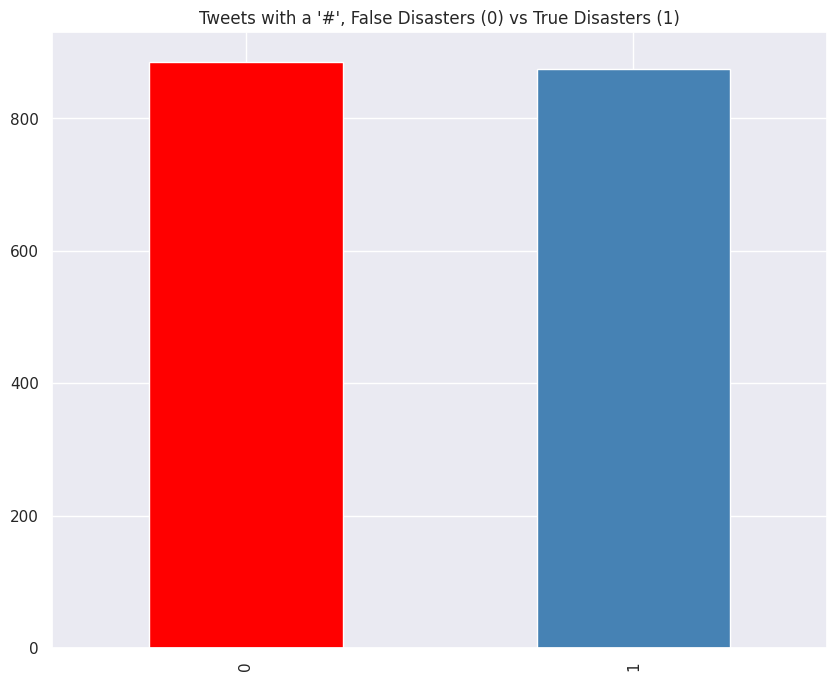

In [ ]:

barplot2 = source[source['comma']==1]['target'].value_counts()
barplot2.plot(kind = 'bar', figsize=(10,8), color = ['red', 'steelblue'])
plt.title("Tweets with a '#', False Disasters (0) vs True Disasters (1)")

A hashtag is not an indicator that a label is true

### Average Sentence Size Per Tweet

#### A quick check reveals that the average sentence size is of 15 words for both True and False labels.

Is there a correlation with sentence size and the label? Lets explore:

Average word count for target 0:  14.704744357438969
Average word count for target 1:  15.167532864567411


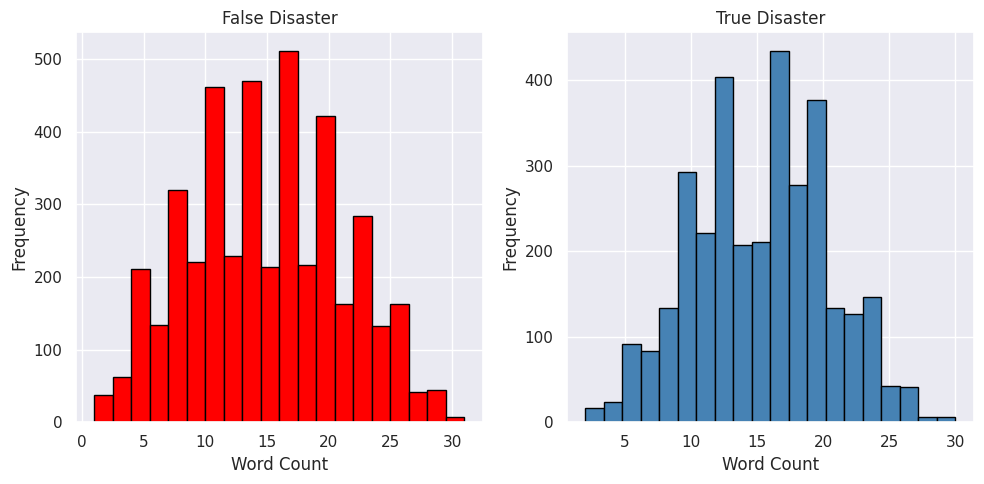

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for i, target in enumerate([0, 1]):
    text_list = tweets_df[tweets_df['target'] == target]['text']
    word_list = [len(text.split()) for text in text_list]
    word_count = sum(word_list)
    average_word_count = word_count / len(text_list)
    print(f"Average word count for target {target}: ", average_word_count)
    if i==0:
      axs[i].hist(word_list, bins=20, color='red', edgecolor='black')
    else:
      axs[i].hist(word_list, bins=20, color='steelblue', edgecolor='black')

    axs[i].set_title('True Disaster' if target == 1 else 'False Disaster')
    axs[i].set_xlabel('Word Count')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


###The average sentence size is the same for false vs true labels

#End of Initial Exploratory analysis, next Sentiment Analysis